In [1]:
# plotting setup
import matplotlib.pyplot as plt
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

### Data

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from keras import layers
from keras import callbacks

spotify = pd.read_csv('data/spotify.csv')

X = spotify.copy().dropna() # drop rows with missing values
y = X.pop('track_popularity') # this is the label
artists = X['track_artist'] # just to have this as a separate variable

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


### A Linear Model

Minimum Validation Loss: 0.2000


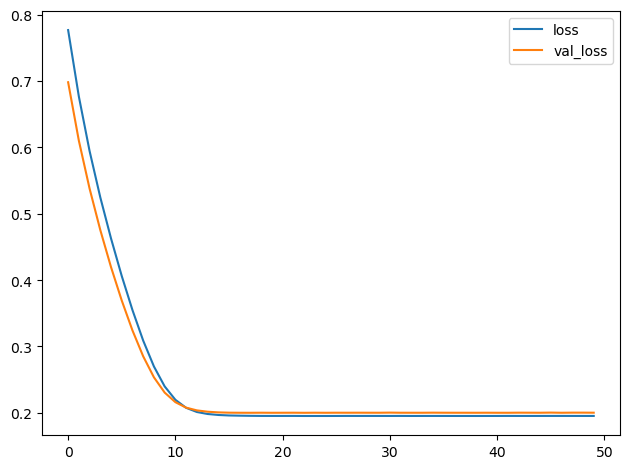

In [5]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Here, the final part of training hard to see, so let's start at epoch 10 instead.

Minimum Validation Loss: 0.2000


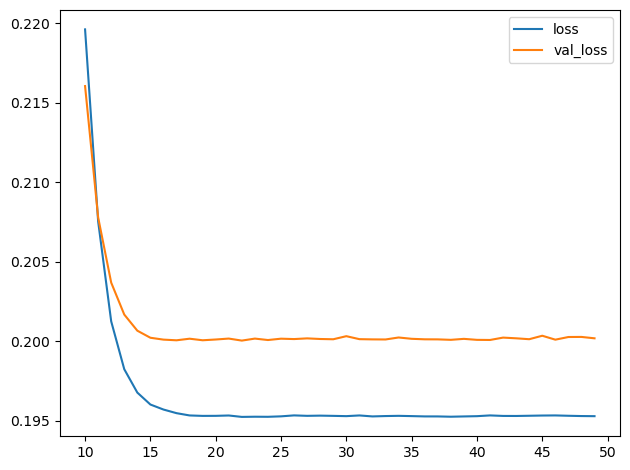

In [6]:
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

The gap between these curves is quite small and the validation loss never increases, so it's more likely that the network is underfitting than overfitting. It would be worth experimenting with more capacity to see if that's the case.

Now let's add some capacity to our network. We'll add three hidden layers with 128 units each.

Epoch 1/50
48/48 [==============================] - 1s 4ms/step - loss: 0.2185 - val_loss: 0.2068
Epoch 2/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1978 - val_loss: 0.2012
Epoch 3/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1932 - val_loss: 0.2003
Epoch 4/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1902 - val_loss: 0.1995
Epoch 5/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1893 - val_loss: 0.2001
Epoch 6/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1869 - val_loss: 0.1984
Epoch 7/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1858 - val_loss: 0.1983
Epoch 8/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1844 - val_loss: 0.1991
Epoch 9/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1838 - val_loss: 0.2002
Epoch 10/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1835 - val_loss: 0.1984
Epoch 11/50
48/48 [

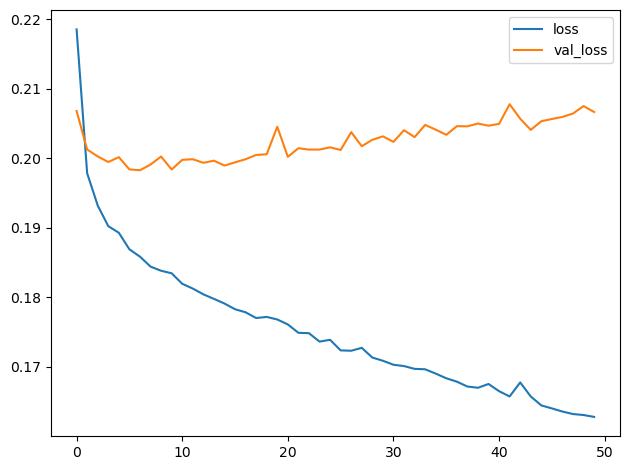

In [7]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Now the validation loss begins to rise very early, while the training loss continues to decrease. This indicates that the network has begun to overfit. At this point, we would need to try something to prevent it, either by reducing the number of units or through a method like early stopping.

### Preventing Overfit: Early Stopping Callback

In [8]:
early_stopping = callbacks.EarlyStopping(
    min_delta = 0.001, # minimium amount of change to count as an improvement
    patience = 5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

### Training

Epoch 1/50
48/48 [==============================] - 1s 4ms/step - loss: 0.2743 - val_loss: 0.2145
Epoch 2/50
48/48 [==============================] - 0s 2ms/step - loss: 0.2046 - val_loss: 0.2073
Epoch 3/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1979 - val_loss: 0.2035
Epoch 4/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1942 - val_loss: 0.2012
Epoch 5/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1917 - val_loss: 0.2007
Epoch 6/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1903 - val_loss: 0.2009
Epoch 7/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1884 - val_loss: 0.2007
Epoch 8/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1873 - val_loss: 0.2007
Epoch 9/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1868 - val_loss: 0.2004
Epoch 10/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1854 - val_loss: 0.1998
Epoch 11/50
48/48 [

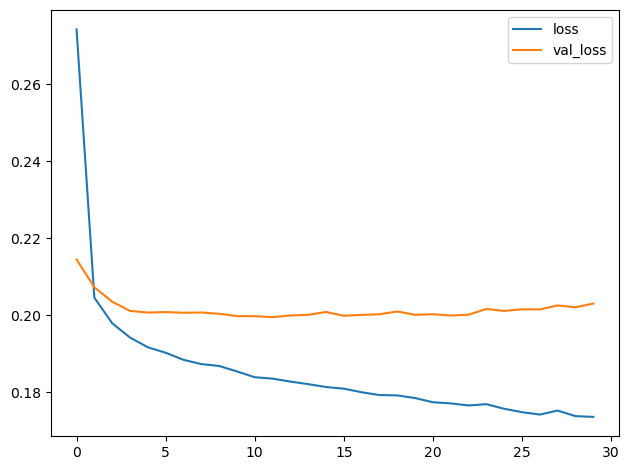

In [9]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Here, the early stopping callback did stop the training once the network began overfitting. Moreover, by including `restore_best_weights` we still get to keep the model where validation loss was lowest.